<h1>Assignment 2 Group 10 (Renk, Leon and Payal) </h1>

In [5]:
import tarfile
import pandas as pd
import os

In [6]:
def count_png_files_in_folder(folder_path):
    png_count = 0
    
    for root, dirs, files in os.walk(folder_path):
        png_count += sum(1 for file in files if file.endswith('.png'))
    return png_count

count_png_files_in_folder("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1")


0

Import data to df with Benign/Malignant IDs and choosing magnification

In [7]:
def extract_image_labels(folder_path, magnification_lvl): 
    file_paths = []
    labels = []

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levels
                    
                # Filter for images with 100x magnification
                if magnification == str(magnification_lvl):
                    labels.append(label)
                    file_paths.append(file_path)
    
    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'FilePath': file_paths,
        'Label': labels
    })
    
    return df


In [8]:
image_labels_df = extract_image_labels("/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1", 100)

In [9]:
image_labels_df.head(5)

,FilePath,Label


<h3> Split data into train. test and validation sets </h3>

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
labels = image_labels_df['Label']

X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

ValueError: With n_samples=0, test_size=0.3 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Convert Labels to Numeric
label_mapping = {'M': 1, 'B': 0}
X_train['Label'] = X_train['Label'].map(label_mapping)
X_val['Label'] = X_val['Label'].map(label_mapping)
X_test['Label'] = X_test['Label'].map(label_mapping)

<h3> Distribution of train, test and validation Datasets </h3>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

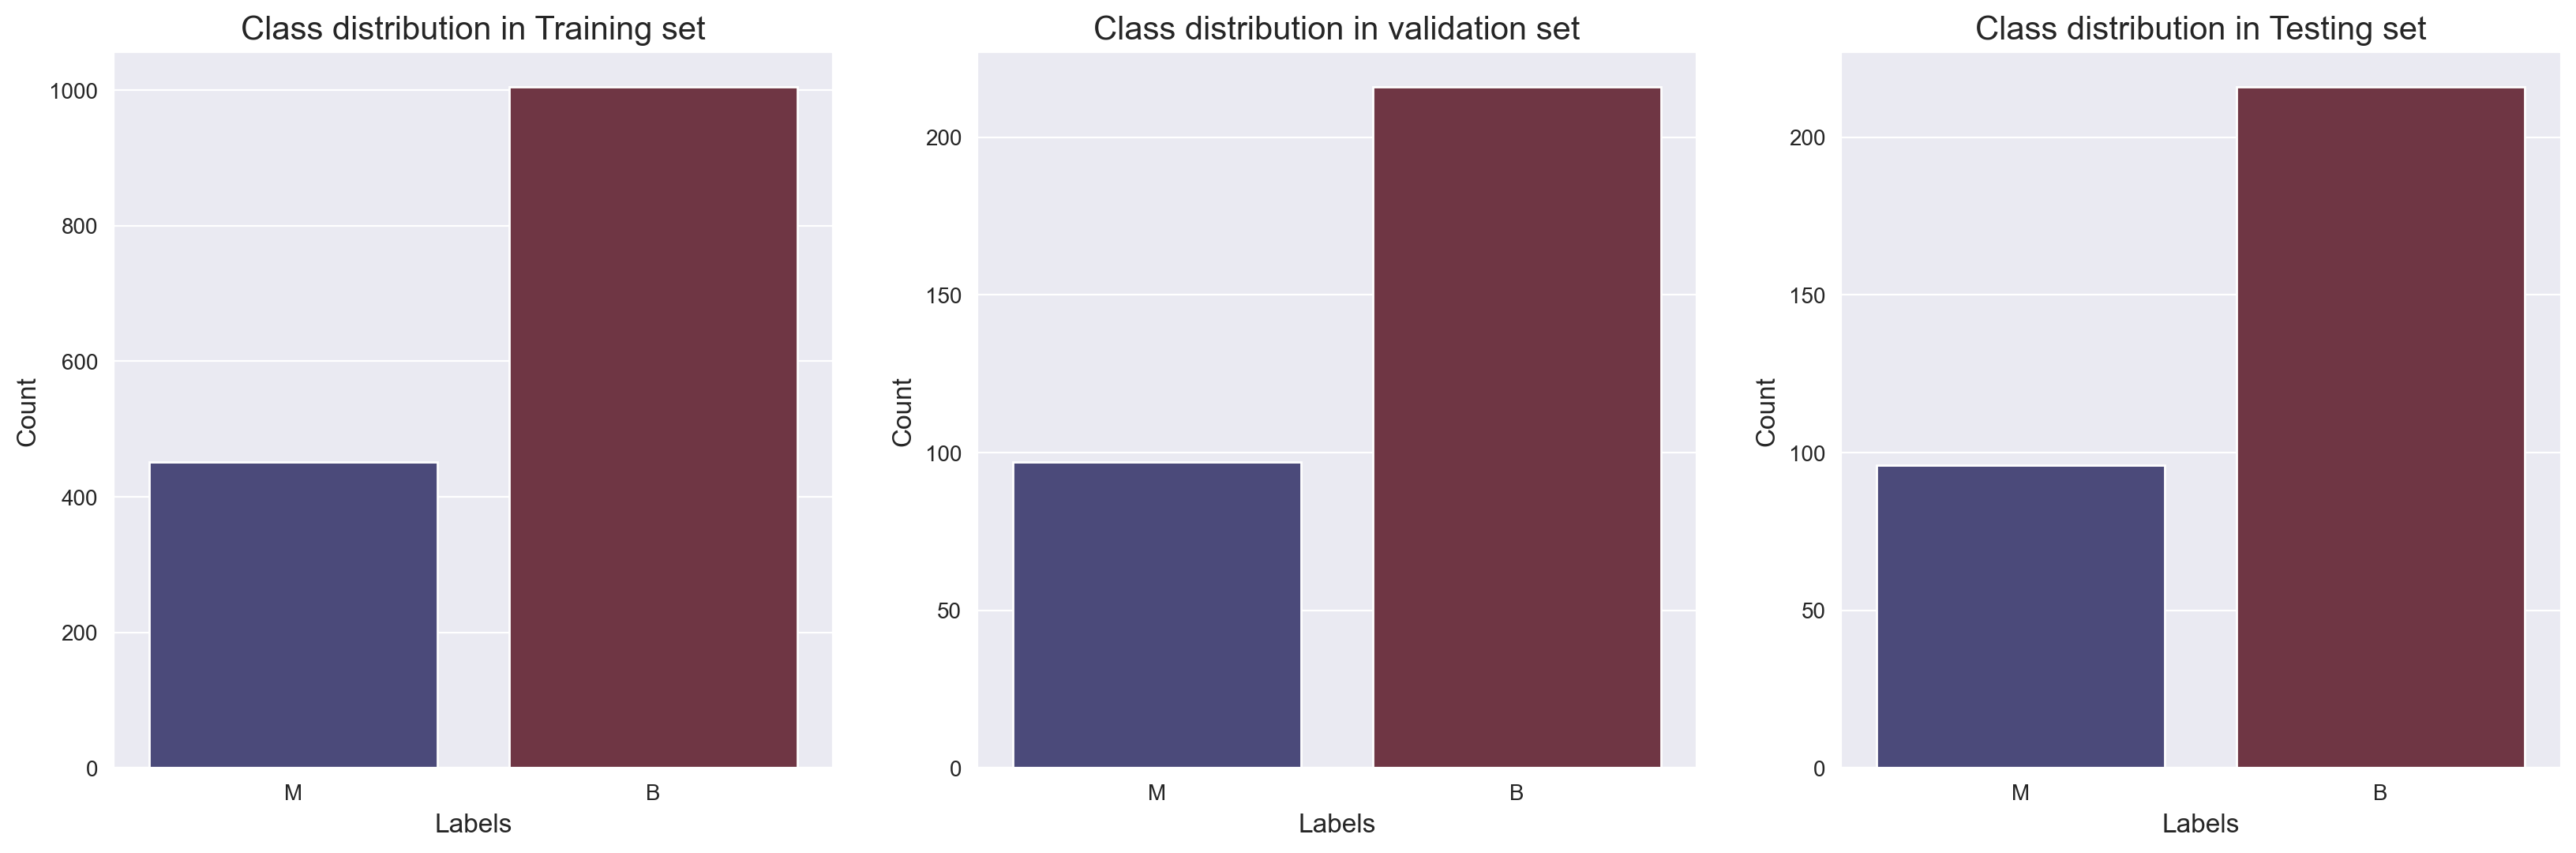

In [ ]:
labels = ['M','B']

#count unique label appearances
label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

# DataFrames with 1 column for count of labels, label names in index
uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])

plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index, y='Count1', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index, y='Count2', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index, y='Count3', hue=uni1.index, palette='icefire', legend=False).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

<h2> Deep Learning based Classifiers </h2>

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.metrics import Precision, Recall

<h3> CNN </h3>

In [ ]:
# Load and preprocess data
IMG_SIZE = (32, 32)  # Adjust

def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0 # Normalize pixel values to [0, 1]
    return image

In [ ]:
base_dir = "/Users/renkasik/Desktop/Intro To Focus Areas/data/BreaKHis_v1"

In [ ]:
# Convert DataFrame columns to lists
train_filepaths = X_train['FilePath'].tolist()
train_labels = X_train['Label'].tolist()

val_filepaths = X_val['FilePath'].tolist()
val_labels = X_val['Label'].tolist()

test_filepaths = X_test['FilePath'].tolist()
test_labels = X_test['Label'].tolist()

# load images and labels as TensorFlow Datasets
def create_dataset(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    
    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

Data Augmentation

In [ ]:
# Define the augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),   # Randomly flip images horizontally
    tf.keras.layers.RandomRotation(0.2),        # Rotate images by up to 20%
    tf.keras.layers.RandomZoom(0.2),            # Zoom up to 20%
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

In [ ]:
i = 0
for filepath in train_filepaths:
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")

In [ ]:
BATCH_SIZE = 32  # Set the batch size according to memory capacity

# Shuffle, batch, and prefetch the datasets
train_ds = (create_dataset(train_filepaths, train_labels)
            .shuffle(buffer_size=len(train_filepaths))
            .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.experimental.AUTOTUNE))
val_ds = create_dataset(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = create_dataset(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

2024-11-03 22:46:26.680630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input_shape to image dimensions, (3,3) is filter size, 3 is RGB color channels
    layers.MaxPooling2D((2, 2)), # reduces each dimension (height and width) by half, summarizing the main features
    layers.Conv2D(64, (3, 3), activation='relu'), # 64 filters
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # number of neurons in the layer
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 4s 24ms/step - loss: 0.6124 - accuracy: 0.6820 - precision: 0.6903 - recall: 0.9781 - val_loss: 0.5315 - val_accuracy: 0.6901 - val_precision: 0.6901 - val_recall: 1.0000
Epoch 2/10
46/46 [==============================] - 3s 19ms/step - loss: 0.5503 - accuracy: 0.6909 - precision: 0.7170 - recall: 0.9124 - val_loss: 0.4987 - val_accuracy: 0.7061 - val_precision: 0.7013 - val_recall: 1.0000
Epoch 3/10
46/46 [==============================] - 3s 19ms/step - loss: 0.5049 - accuracy: 0.7706 - precision: 0.7846 - recall: 0.9204 - val_loss: 0.4445 - val_accuracy: 0.8147 - val_precision: 0.8559 - val_recall: 0.8796
Epoch 4/10
46/46 [==============================] - 3s 21ms/step - loss: 0.4855 - accuracy: 0.8001 - precision: 0.8121 - recall: 0.9244 - val_loss: 0.4489 - val_accuracy: 0.8019 - val_precision: 0.7873 - val_recall: 0.9769
Epoch 5/10
46/46 [==============================] - 3s 20ms/step - loss: 0.4713 - accuracy: 0.7919 - precisi

In [ ]:
results = model.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results)):
    print(metrics[i] + ': ' + str(results[i]))

10/10 [==============================] - 1s 47ms/step - loss: 0.4197 - accuracy: 0.8301 - precision: 0.8123 - recall: 0.9815
Loss: 0.4197402894496918
Accuracy: 0.8301281929016113
Precision: 0.8122605085372925
Recall(Sensitivity): 0.9814814925193787


<h3>Fully connected NN with one hidden layer </h3>

In [ ]:
model_2 = models.Sequential([
    layers.Flatten(input_shape=(32, 32, 3)),  # fully connected -> flatten from 2D to 1D
    layers.Dense(64, activation='relu'),  # hidden layer -> learning features from the input data
    layers.Dense(1, activation='sigmoid') 
])

In [ ]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [ ]:
history_2 = model_2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 3s 11ms/step - loss: 0.6636 - accuracy: 0.6882 - precision_1: 0.7181 - recall_1: 0.9025 - val_loss: 0.5449 - val_accuracy: 0.6901 - val_precision_1: 0.6901 - val_recall_1: 1.0000
Epoch 2/10
46/46 [==============================] - 2s 11ms/step - loss: 0.5282 - accuracy: 0.7521 - precision_1: 0.7683 - recall_1: 0.9174 - val_loss: 0.5204 - val_accuracy: 0.6965 - val_precision_1: 0.6945 - val_recall_1: 1.0000
Epoch 3/10
46/46 [==============================] - 2s 11ms/step - loss: 0.5315 - accuracy: 0.7376 - precision_1: 0.7754 - recall_1: 0.8726 - val_loss: 0.5490 - val_accuracy: 0.6901 - val_precision_1: 0.6901 - val_recall_1: 1.0000
Epoch 4/10
46/46 [==============================] - 2s 11ms/step - loss: 0.5168 - accuracy: 0.7754 - precision_1: 0.7995 - recall_1: 0.9005 - val_loss: 0.5154 - val_accuracy: 0.7157 - val_precision_1: 0.7096 - val_recall_1: 0.9954
Epoch 5/10
46/46 [==============================] - 2s 11ms/step - loss: 0.5

In [ ]:
results_2 = model_2.evaluate(test_ds)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_2)):
    print(metrics[i] + ': ' + str(results_2[i]))

10/10 [==============================] - 0s 43ms/step - loss: 0.4393 - accuracy: 0.8429 - precision_1: 0.8465 - recall_1: 0.9444
Loss: 0.4392950236797333
Accuracy: 0.8429487347602844
Precision: 0.8464730381965637
Recall(Sensitivity): 0.9444444179534912


<h3>ResNet-50 </h3>

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
IMG_SIZE_resnet = (224, 224) #ResNet50 input size requirement

def load_and_preprocess_image_resnet(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE_resnet)
    image = tf.keras.applications.resnet50.preprocess_input(image) #ResNet preprocessing
    return image

In [ ]:
def create_dataset_resnet(filepaths, labels):    
    # Create TensorFlow datasets from paths and labels for ResNet
    filepaths_ds = tf.data.Dataset.from_tensor_slices(filepaths)
    images_ds = filepaths_ds.map(load_and_preprocess_image_resnet, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)

    # Zip the datasets together
    return tf.data.Dataset.zip((images_ds, labels_ds))

In [ ]:
# Shuffle, batch, and prefetch the datasets
train_ds_resnet = (create_dataset_resnet(train_filepaths, train_labels)
                   .shuffle(buffer_size=len(train_filepaths))
                   .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.experimental.AUTOTUNE))
val_ds_resnet = create_dataset_resnet(val_filepaths, val_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_ds_resnet = create_dataset_resnet(test_filepaths, test_labels).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #without the top classification layer to add custom classification layers later
base_model.trainable = False  #freeze base model to avoid fine tuning

In [ ]:
model_3 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), #reduce output to single vector
    layers.Dense(1, activation='sigmoid')  
])

In [ ]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

In [ ]:
history_3 = model_3.fit(train_ds_resnet,
                    validation_data=val_ds_resnet,
                    epochs=10)

Epoch 1/10
46/46 [==============================] - 84s 2s/step - loss: 0.4806 - accuracy: 0.7788 - precision_2: 0.7952 - recall_2: 0.9154 - val_loss: 0.3903 - val_accuracy: 0.8466 - val_precision_2: 0.8750 - val_recall_2: 0.9074
Epoch 2/10
46/46 [==============================] - 81s 2s/step - loss: 0.3158 - accuracy: 0.8695 - precision_2: 0.8812 - recall_2: 0.9373 - val_loss: 0.3241 - val_accuracy: 0.8626 - val_precision_2: 0.9061 - val_recall_2: 0.8935
Epoch 3/10
46/46 [==============================] - 83s 2s/step - loss: 0.2637 - accuracy: 0.9038 - precision_2: 0.9139 - recall_2: 0.9502 - val_loss: 0.2798 - val_accuracy: 0.9137 - val_precision_2: 0.9163 - val_recall_2: 0.9630
Epoch 4/10
46/46 [==============================] - 101s 2s/step - loss: 0.2247 - accuracy: 0.9196 - precision_2: 0.9237 - recall_2: 0.9632 - val_loss: 0.2682 - val_accuracy: 0.9042 - val_precision_2: 0.9429 - val_recall_2: 0.9167
Epoch 5/10
46/46 [==============================] - 99s 2s/step - loss: 0.2050 

In [ ]:
#fine tuning
base_model.trainable = True
model_3.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  #lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

history_3 = model_3.fit(train_ds_resnet,
                    validation_data=val_ds_resnet,
                    epochs=5)

Epoch 1/5
46/46 [==============================] - 288s 6s/step - loss: 0.5493 - accuracy: 0.7548 - precision_4: 0.9589 - recall_4: 0.6736 - val_loss: 0.3049 - val_accuracy: 0.8722 - val_precision_4: 0.8465 - val_recall_4: 0.9954
Epoch 2/5
46/46 [==============================] - 281s 6s/step - loss: 0.1458 - accuracy: 0.9602 - precision_4: 0.9876 - recall_4: 0.9542 - val_loss: 0.2671 - val_accuracy: 0.8882 - val_precision_4: 0.8664 - val_recall_4: 0.9907
Epoch 3/5
46/46 [==============================] - 285s 6s/step - loss: 0.0737 - accuracy: 0.9890 - precision_4: 0.9920 - recall_4: 0.9920 - val_loss: 0.2373 - val_accuracy: 0.9042 - val_precision_4: 0.8875 - val_recall_4: 0.9861
Epoch 4/5
46/46 [==============================] - 284s 6s/step - loss: 0.0433 - accuracy: 0.9973 - precision_4: 0.9970 - recall_4: 0.9990 - val_loss: 0.1919 - val_accuracy: 0.9201 - val_precision_4: 0.9064 - val_recall_4: 0.9861
Epoch 5/5
46/46 [==============================] - 285s 6s/step - loss: 0.0298 -

In [ ]:
results_3 = model_3.evaluate(test_ds_resnet)
metrics = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
for i in range(len(results_3)):
    print(metrics[i] + ': ' + str(results_3[i]))

10/10 [==============================] - 14s 1s/step - loss: 0.1974 - accuracy: 0.9199 - precision_4: 0.9099 - recall_4: 0.9815
Loss: 0.19740530848503113
Accuracy: 0.9198718070983887
Precision: 0.9098712205886841
Recall(Sensitivity): 0.9814814925193787


<h3>Plots</h3>

In [ ]:
results = np.array(results)
results_2 = np.array(results_2)
results_3 = np.array(results_3)
results_df = pd.DataFrame({'CNN': results, 'Shallow NN': results_2, 'ResNet50': results_3})

results_df = results_df.T

results_df.columns = ['Loss', 'Accuracy', 'Precision', 'Recall(Sensitivity)']
results_df

,Loss,Accuracy,Precision,Recall(Sensitivity)
CNN,0.419740,0.830128,0.812261,0.981481
Shallow NN,0.439295,0.842949,0.846473,0.944444
ResNet50,0.197405,0.919872,0.909871,0.981481


<Figure size 1440x1080 with 0 Axes>

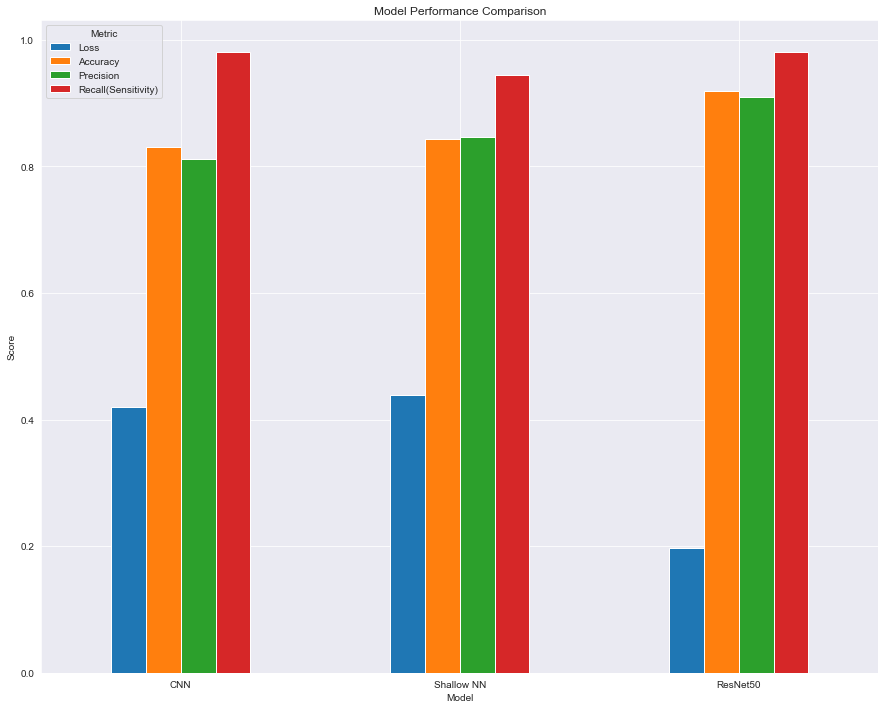

In [ ]:

plt.figure(figsize=(20, 15))

results_df.plot(kind='bar', rot=0, figsize=(15,12))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')  

# Show the plot
plt.legend(title='Metric')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
X_test_images = np.array([load_and_preprocess_image(fp) for fp in X_test['FilePath']])
X_test_images_resnet = np.array([load_and_preprocess_image_resnet(fp) for fp in X_test['FilePath']])

probabilities_CNN = model.predict(X_test_images)
probabilities_ShallowNN = model_2.predict(X_test_images)
probabilities_ResNet50 = model_3.predict(X_test_images_resnet)


10/10 [==============================] - 15s 1s/step


In [ ]:
fpr_CNN, tpr_CNN, _ = roc_curve(test_labels, probabilities_CNN)
fpr_ShallowNN, tpr_ShallowNN, _ = roc_curve(test_labels, probabilities_ShallowNN)
fpr_ResNet50, tpr_ResNet50, _ = roc_curve(test_labels, probabilities_ResNet50)

auc_CNN = auc(fpr_CNN, tpr_CNN)
auc_ShallowNN = auc(fpr_ShallowNN, tpr_ShallowNN)
auc_ResNet50 = auc(fpr_ResNet50, tpr_ResNet50)

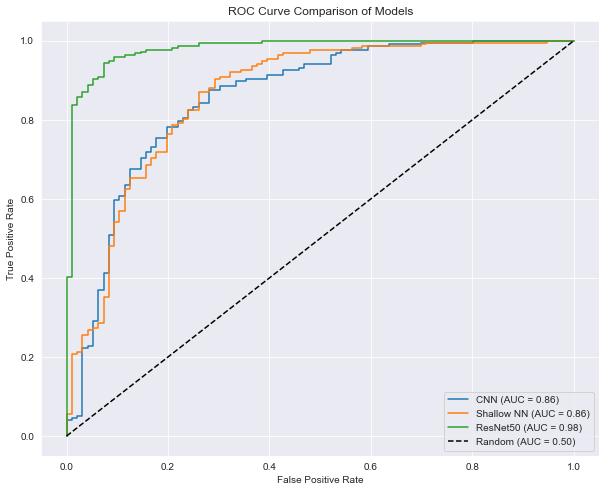

In [ ]:
plt.figure(figsize=(10, 8))


plt.plot(fpr_CNN, tpr_CNN, label=f'CNN (AUC = {auc_CNN:.2f})')
plt.plot(fpr_ShallowNN, tpr_ShallowNN, label=f'Shallow NN (AUC = {auc_ShallowNN:.2f})')
plt.plot(fpr_ResNet50, tpr_ResNet50, label=f'ResNet50 (AUC = {auc_ResNet50:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc='lower right')
plt.show()